# <span style="color: #51e2f5;">What drives the price of a car?</span>

![](../images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

## <span style="color: #9df9ef;">CRISP-DM Framework</span>

<center>
    <img src = ../images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

## <span style="color: #9df9ef;">Business Understanding</span>

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

### <span style="color: #edf756;"> Data-task reframing </span>

Turn the business question — “what drives the price of a used car?” — into a supervised learning and explanatory-data-analysis problem: build and validate a predictive regression model that estimates a car’s sale price from its attributes (make, model, year, mileage, trim, fuel/engine type, transmission, location, condition, etc.), and use interpretable model-analysis (feature importance, partial dependence, SHAP) and rigorous EDA to identify the causal / correlational drivers of price. 

**Objective:** Predict price (continuous target) and rank the features that most strongly influence price while controlling for confounders and avoiding target leakage.

**Approach:** perform data cleaning (missing-data treatment, outlier detection), feature engineering (age, mileage-per-year, market-region indicators), categorical encoding, and exploratory analysis; train several regression models (linear models with regularization, tree-based models like Random Forest / XGBoost); evaluate with cross-validated metrics (MAE, RMSE, R²) and robustness checks.

**Interpretability & business output:** use global and local explainability (feature importances, partial dependence plots, SHAP values) to produce clear, actionable recommendations for the dealership (which attributes to highlight, which trade-ins to prioritize, pricing adjustments by age/mileage/brand/region).

**Success criteria:** a validated model with acceptable predictive error (business-defined MAE or RMSE threshold), stable feature ranking across models, and a short list of actionable drivers that explain price variance and map to dealership decisions (pricing, procurement, marketing).

### <span style="color: #edf756;"> Data Problem Definition (CRISP-DM): </span>
This project is a supervised machine learning regression task where the goal is to model and predict the continuous target variable price using vehicle attributes such as make, model, year, mileage, condition, and specifications. We will perform data preparation, including cleaning, transformation, and feature engineering, followed by exploratory data analysis (EDA) to understand patterns and correlations. The objective is to build an interpretable regression model and use feature importance and related analytical techniques to determine which variables most significantly influence used-car prices.

### <span style="color: #edf756;"> Data Understanding </span>

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

#### <span style="color: #ffa8B6;"> 1. Load and Inspect the Raw Data </span>
- Review dataset size (rows, columns) and data types.
- Display sample records to see how values are represented.
- Check for column descriptions or metadata.

#### <span style="color: #ffa8B6;"> 2. Assess Data Completeness </span>
- Identify missing values in each column.
- Analyze missingness patterns (random vs. systematic).
- Flag fields with high missing rates for potential removal or imputation.

#### <span style="color: #ffa8B6;"> 3. Evaluate Data Quality </span>
- Look for inconsistent or impossible values  for example negative mileage, future model years, price = 0.
- Identify duplicate entries.
- Detect outliers using histograms, boxplots, IQR, or z-scores.

#### <span style="color: #ffa8B6;"> 4. Understand Variable Distributions </span>
- Plot histograms and density curves for numerical variables.
- Review category frequencies for categorical variables.
- Identify dominant categories that may introduce imbalance.

#### <span style="color: #ffa8B6;"> 5. Explore Relationships Between Variables </span>
- Compute correlation matrices for numeric fields.
- Use scatter plots or boxplots to visualize relationships with price.
- Investigate interactions for example, mileage vs. price across different brands.

#### <span style="color: #ffa8B6;"> 6. Identify Potential Feature Engineering Needs </span>
- Consider new features such as:  
  - *Vehicle age* (current year – model year)  
  - *Mileage per year*  
  - *Brand segment* (Pickup, Truck, SUV, HAtchback)  
  - *Regional indicators*

#### <span style="color: #ffa8B6;"> 7. Validate Data Relevance to the Business Objective </span>
- Assess whether available data supports the goal of predicting car prices.
- Ensure essential factors for example condition, make/model, cylinders, etc. are present.
- Align dataset capabilities with dealership questions.

#### <span style="color: #ffa8B6;"> 8. Document Data Limitations </span>
- Note missing attributes that might impact model fidelity.
- Identify sampling or geographic biases.
- Record assumptions that may require clarification.

##### <span style="color: #a28089;"> Notes: </span>

## <span style="color: #9df9ef;"> Data Preparation </span>

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

### <span style="color: #edf756;"> Imports </span>

In [38]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt 
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from sklearn.inspection import PartialDependenceDisplay
from sklearn.preprocessing import StandardScaler

import sys
from pathlib import Path

parent = Path.cwd().parent
sys.path.insert(0, str(parent))

from helpers.data_cleaners import summary_stats

import warnings
warnings.filterwarnings("ignore")

### <span style="color: #edf756;"> Load Data </span>

In [2]:
df = pd.read_csv('../data/vehicles.csv')

### <span style="color: #edf756;"> Raw Data Stats </span>
Use summary_stats and look for columns that are all unique (too much variation) and not unique at all (no variation)

In [3]:
summary_stats(df)

,dtype,sample_val,vals,miss_cnt,miss_pct,unique,mean,mode,min,max,std,skew,kurtosis
id,int64,7304918093,426880,0,0.0,426880,7.311487e+09,7.207408e+09,7.207408e+09,7.317101e+09,4473170.41,-1.4,17.1
region,object,north central FL,426880,0,0.0,404,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,int64,22389,426880,0,0.0,15655,7.519903e+04,0.000000e+00,0.000000e+00,3.736929e+09,12182282.17,254.4,69205.1
year,float64,2007.0,425675,1205,0.3,114,2.011240e+03,2.017000e+03,1.900000e+03,2.022000e+03,9.45,-3.6,19.6
manufacturer,object,honda,409234,17646,4.1,42,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model,object,f-150,421603,5277,1.2,29649,NaN,NaN,NaN,NaN,NaN,NaN,NaN
condition,object,good,252776,174104,40.8,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cylinders,object,4 cylinders,249202,177678,41.6,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fuel,object,gas,423867,3013,0.7,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
odometer,float64,131337.0,422480,4400,1.0,104870,9.804333e+04,1.000000e+05,0.000000e+00,1.000000e+07,213881.50,38.0,1690.8


#### <span style="color: #ffa8B6;"> Data Cleaning and Encoding </span>

In [16]:
# Basic filters (tune thresholds after EDA)
current_year = pd.Timestamp.today().year
df = df[(df['price'] >= 1000) & (df['price'] <= 150000)]
df = df[(df['year'] >= 1990) & (df['year'] <= current_year)]
df = df[(df['odometer'] >= 0) & (df['odometer'] <= 400000)]

# Title/status filter (primary analysis)
df = df[df['title_status'].str.lower().isin(['clean', 'lien', 'missing'])]  # adjust if needed

# Derived features
df['age'] = current_year - df['year']
df['log_price'] = np.log1p(df['price'])
df['log_odometer'] = np.log1p(df['odometer'])

# Condition ordinal map
cond_map = {
    'salvage': 0, 'fair': 1, 'good': 2,
    'excellent': 3, 'like new': 4, 'new': 5
}
df['condition_ord'] = df['condition'].str.lower().map(cond_map)

# Select features
features = [
    'age', 'log_odometer', 'condition_ord', 'cylinders',
    'fuel', 'transmission', 'drive', 'type', 'paint_color',
    'manufacturer', 'state', 'title_status'
]
use_cols = ['log_price'] + features
df_model = df[use_cols].dropna()

# One-hot encode categoricals
cat_cols = ['fuel', 'transmission', 'drive', 'type', 'paint_color', 'manufacturer', 'state', 'title_status']
df_model = pd.get_dummies(df_model, columns=cat_cols, drop_first=True)

df['paint_color'] = df['paint_color'].fillna('unknown')
df['condition'] = df['condition'].fillna('unknown')
df['odometer'] = df['odometer'].fillna(df['odometer'].median())

df['cylinders'] = df['cylinders'].str.extract('(\d+)')   # extract digits
df['cylinders'] = pd.to_numeric(df['cylinders'], errors='coerce')
df['cylinders'] = df['cylinders'].fillna(df['cylinders'].mode()[0])
df['cylinders'] = df.groupby('manufacturer')['cylinders'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 4)
)


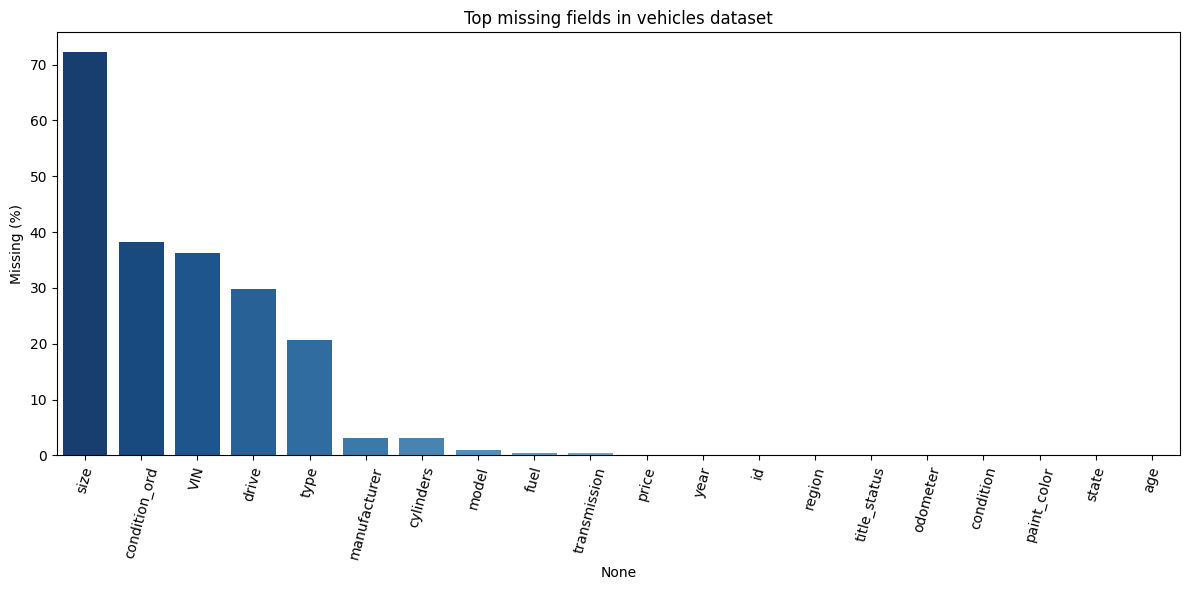

In [26]:
missing_pct = df.isna().mean().sort_values(ascending=False)[:20] * 100
plt.figure(figsize=(12,6))
sns.barplot(x=missing_pct.index, y=missing_pct.values, palette="Blues_r")
plt.xticks(rotation=75)
plt.ylabel("Missing (%)")
plt.title("Top missing fields in vehicles dataset")
plt.tight_layout()
plt.show()

In [17]:
summary_stats(df)

,dtype,sample_val,vals,miss_cnt,miss_pct,unique,mean,mode,min,max,std,skew,kurtosis
id,int64,7311009165,347939,0,0.0,347939,7.311445e+09,7.301583e+09,7.301583e+09,7.317101e+09,4397122.24,-0.6,-0.8
region,object,saginaw-midland-baycity,347939,0,0.0,404,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,int64,15000,347939,0,0.0,14032,1.978536e+04,6.995000e+03,1.000000e+03,1.500000e+05,14725.70,1.5,4.2
year,float64,2005.0,347939,0,0.0,33,2.012290e+03,2.018000e+03,1.990000e+03,2.022000e+03,5.82,-0.9,0.6
manufacturer,object,dodge,337020,10919,3.1,41,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model,object,highlander,344748,3191,0.9,22541,NaN,NaN,NaN,NaN,NaN,NaN,NaN
condition,object,good,347939,0,0.0,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cylinders,float64,6.0,337020,10919,3.1,7,5.980000e+00,6.000000e+00,3.000000e+00,1.200000e+01,1.20,0.1,0.2
fuel,object,diesel,346393,1546,0.4,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
odometer,float64,110205.0,347939,0,0.0,91664,9.354825e+04,2.000000e+05,0.000000e+00,4.000000e+05,63625.58,0.6,0.1


#### <span style="color: #ffa8B6;"> Visualizations to understand data </span>

##### <span style="color: #a28089;"> Average Used Car Price by Manufacturer </span>

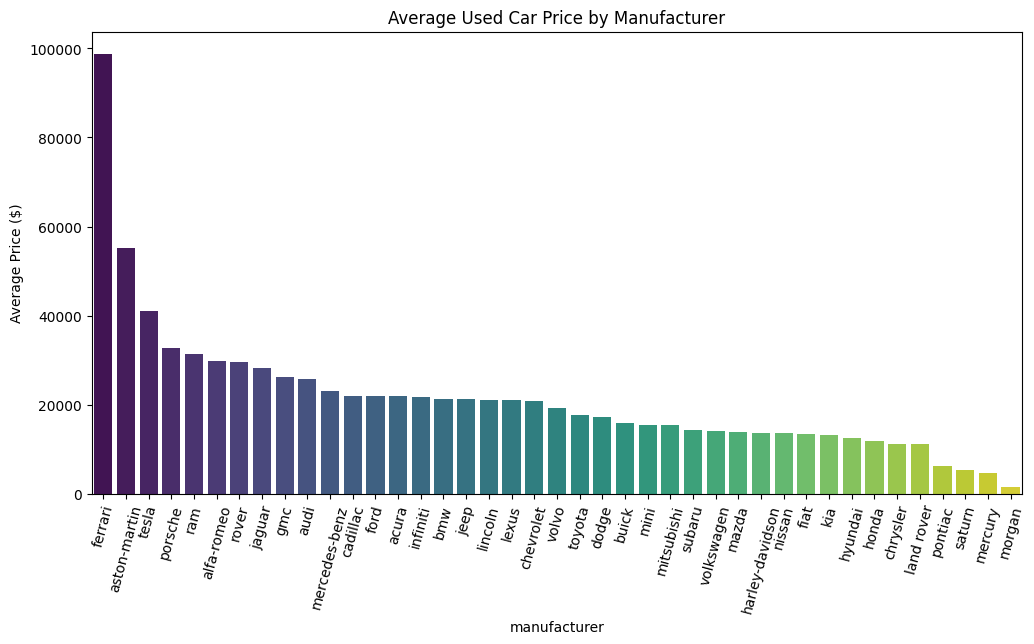

In [18]:
# Clean price range for realism
df = df[(df['price'] >= 1000) & (df['price'] <= 150000)]

# Average price by manufacturer
brand_avg = df.groupby('manufacturer')['price'].mean().sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=brand_avg.index, y=brand_avg.values, palette="viridis")
plt.xticks(rotation=75)
plt.ylabel("Average Price ($)")
plt.title("Average Used Car Price by Manufacturer")
plt.show()


##### <span style="color: #a28089;"> Correlation Heatmap </span>

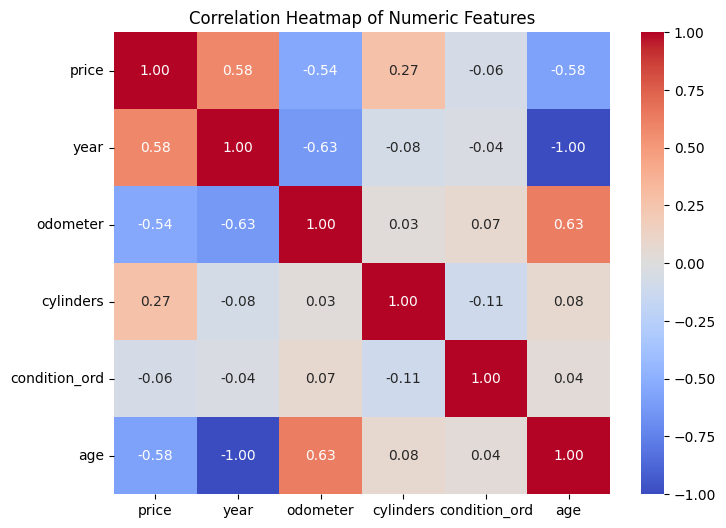

In [19]:
cond_map = {
    'salvage': 0, 'fair': 1, 'good': 2,
    'excellent': 3, 'like new': 4, 'new': 5
}
df['condition_ord'] = df['condition'].str.lower().map(cond_map)

# Select numeric features
num_cols = ['price', 'year', 'odometer', 'cylinders', 'condition_ord', 'age']
corr = df[num_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Numeric Features")
plt.show()


##### <span style="color: #a28089;"> Price vs. Mileage (Depreciation Curve) </span>
**Why:** Shows how quickly cars lose value as mileage increases.

**Dealer insight:** Helps set mileage‑based pricing tiers and identify sweet spots for acquisition.

**Implementation:** Scatterplot with regression line to highlight the trend.

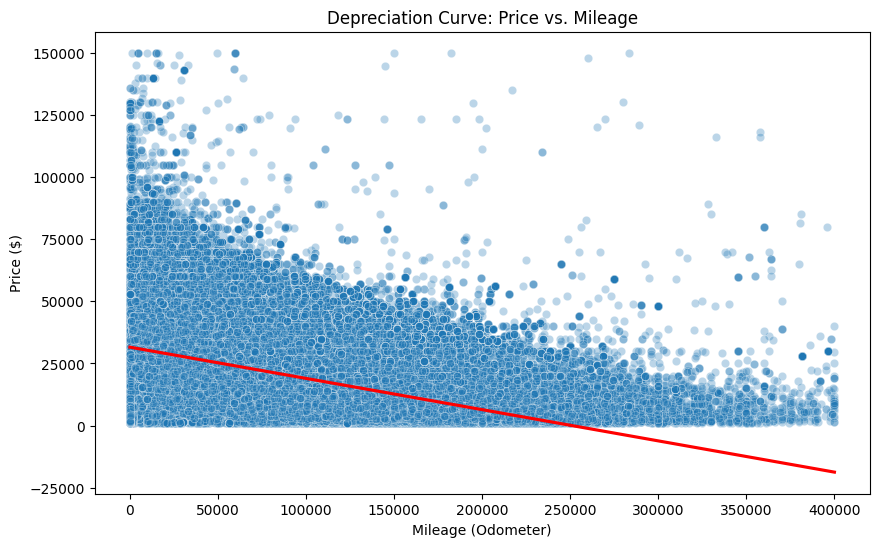

In [20]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='odometer', y='price', alpha=0.3)
sns.regplot(data=df, x='odometer', y='price', scatter=False, color='red')
plt.title("Depreciation Curve: Price vs. Mileage")
plt.xlabel("Mileage (Odometer)")
plt.ylabel("Price ($)")
plt.show()


##### <span style="color: #a28089;"> Boxplot of Price by Condition </span>
**Why:** Quantifies the premium for “excellent” vs. “good” vs. “fair.”

**Dealer insight:** Justifies reconditioning spend when uplift > cost.

**Implementation:** Boxplot grouped by condition categories.

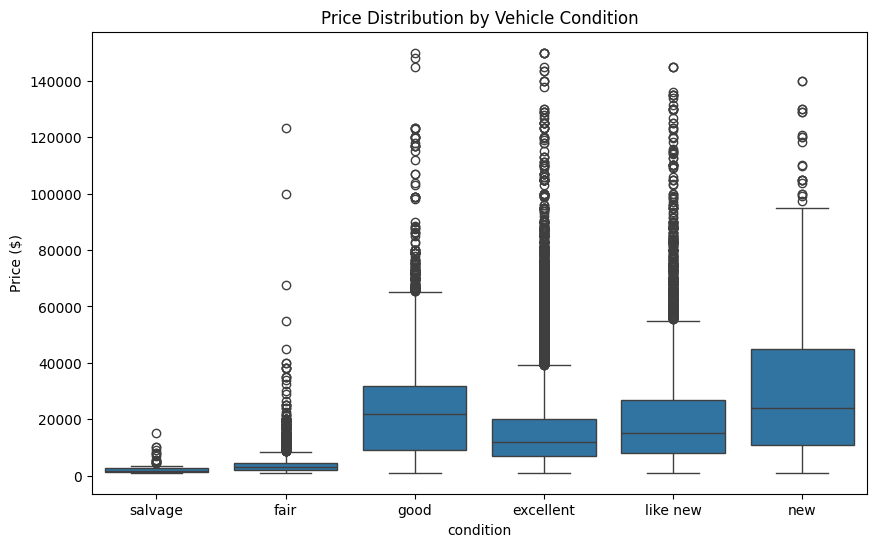

In [21]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='condition', y='price', order=['salvage','fair','good','excellent','like new','new'])
plt.title("Price Distribution by Vehicle Condition")
plt.ylabel("Price ($)")
plt.show()


##### <span style="color: #a28089;"> Average Price by Vehicle Type </span>
**Why:** Compares SUVs, trucks, sedans, coupes, etc.

**Dealer insight:** Reveals which categories command higher resale values.

**Implementation:** Bar chart of mean prices by type.

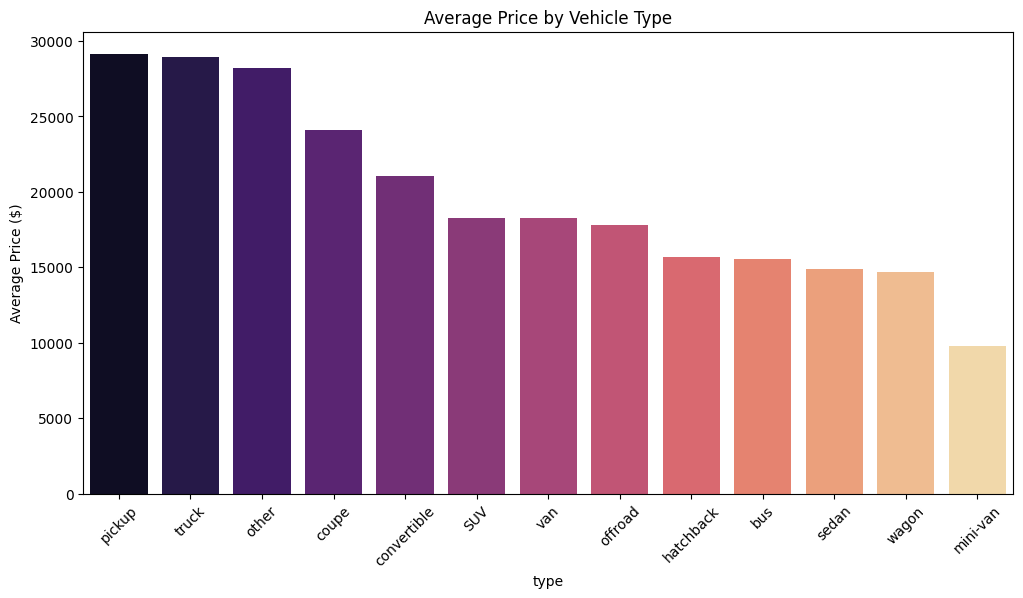

In [22]:
type_avg = df.groupby('type')['price'].mean().sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=type_avg.index, y=type_avg.values, palette="magma")
plt.xticks(rotation=45)
plt.ylabel("Average Price ($)")
plt.title("Average Price by Vehicle Type")
plt.show()


##### <span style="color: #a28089;"> Heatmap of Brand vs. Condition </span>
**Why:** Shows how condition interacts with brand to affect price.

**Dealer insight:** Some brands retain value even in lower conditions, others only sell well when “like new.”

**Implementation:** Pivot table of average price by manufacturer × condition, visualized as a heatmap.

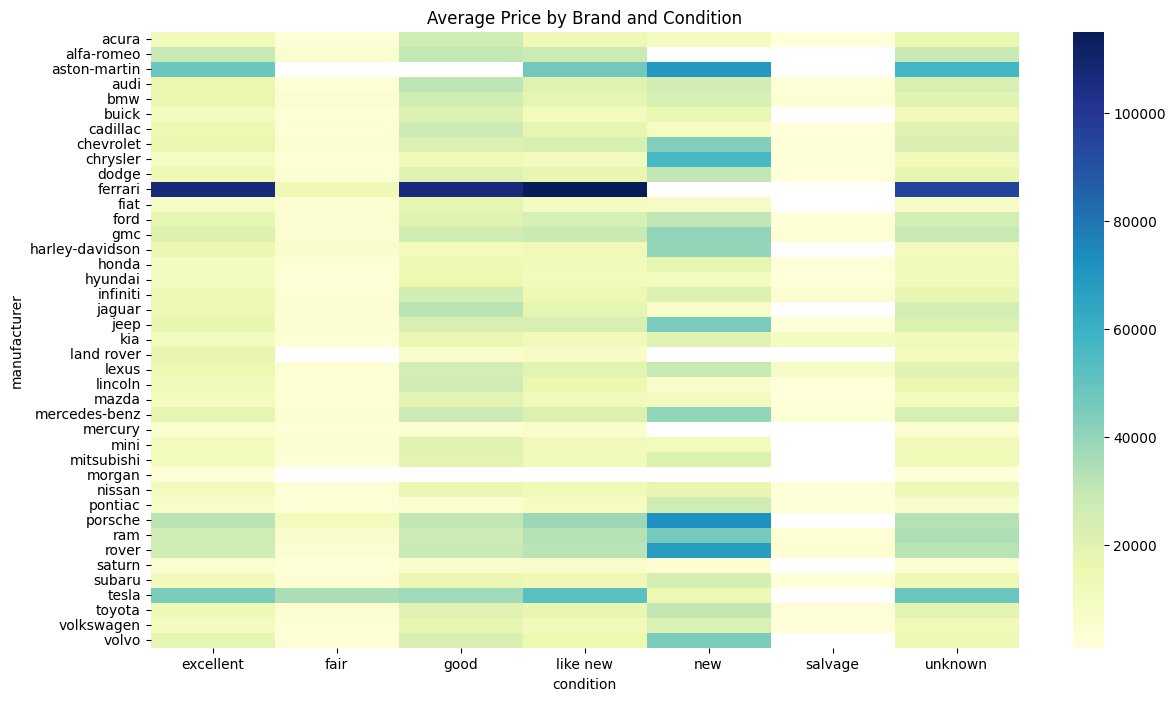

In [23]:
pivot = df.pivot_table(values='price', index='manufacturer', columns='condition', aggfunc='mean')
plt.figure(figsize=(14,8))
sns.heatmap(pivot, cmap="YlGnBu", annot=False)
plt.title("Average Price by Brand and Condition")
plt.show()


##### <span style="color: #a28089;"> Geographic Price Variation </span>
**Why:** Highlights regional demand differences (e.g., trucks in Texas, hybrids in California).

**Dealer insight:** Tailor inventory mix by geography.

**Implementation:** Bar chart of average price by state.

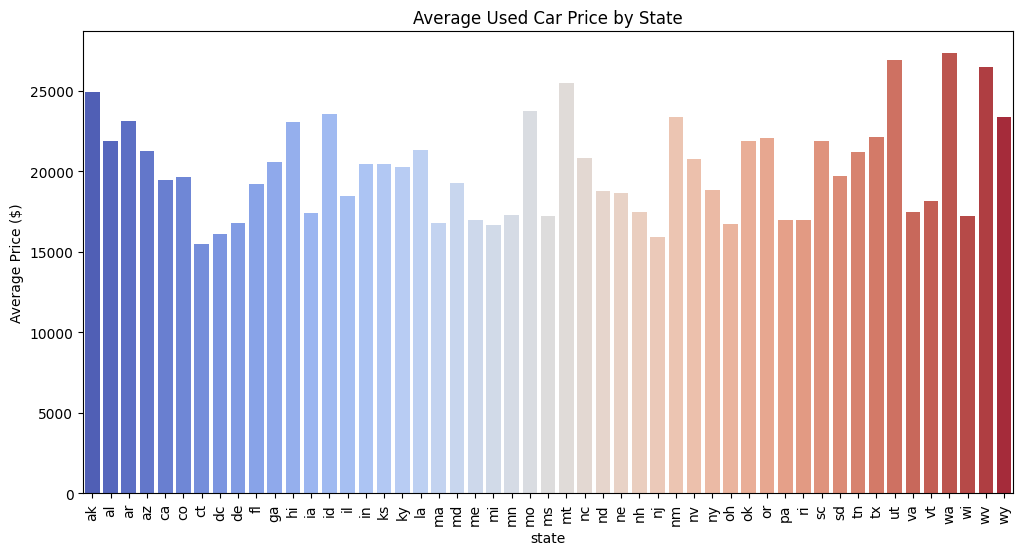

In [24]:
state_avg = df.groupby('state')['price'].mean()

plt.figure(figsize=(12,6))
sns.barplot(x=state_avg.index, y=state_avg.values, palette="coolwarm")
plt.xticks(rotation=90)
plt.ylabel("Average Price ($)")
plt.title("Average Used Car Price by State")
plt.show()


## <span style="color: #9df9ef;"> Modeling </span>

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

## <span style="color: #9df9ef;"> Evaluation </span>

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

#### <span style="color: #ffa8B6;"> Target distribution and train/test split </span>

**Why:** The log transform stabilizes variance and makes residuals more normal; visualizing confirms distribution suitability.

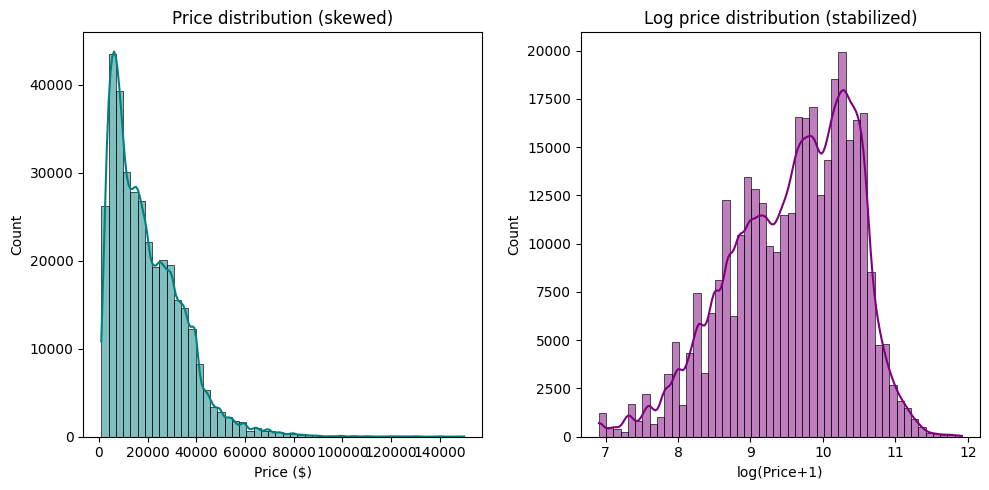

In [27]:
from sklearn.model_selection import train_test_split

# Visualize target distribution
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.histplot(df['price'], bins=50, kde=True, color='teal')
plt.title("Price distribution (skewed)"); plt.xlabel("Price ($)")

plt.subplot(1,2,2)
sns.histplot(df['log_price'], bins=50, kde=True, color='purple')
plt.title("Log price distribution (stabilized)"); plt.xlabel("log(Price+1)")
plt.tight_layout(); plt.show()

# Feature selection and encoding
features = ['age','odometer','cylinders','condition_ord','fuel','transmission',
            'drive','type','manufacturer','state']
use = features + ['log_price']

df_model = df[use].dropna()  # drop rare remaining NAs

X = pd.get_dummies(df_model[features], drop_first=True)
y = df_model['log_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#### <span style="color: #ffa8B6;"> Models, hyperparameters, and cross-validation visualization </span>

**Models:** Linear, Ridge, Lasso, Random Forest, Gradient Boosting (pure sklearn for portability).

**Why CV:** Provides a fair comparison across models, reduces variance from a single split.

**Visualization:** Bar chart of mean CV RMSE by model to communicate performance clearly.

'Linear CV RMSE (log price): 0.3719'

'Ridge (alpha=10) CV RMSE (log price): 0.3721'

'Lasso (alpha=0.001) CV RMSE (log price): 0.3806'

'GradientBoosting CV RMSE (log price): 0.3403'

'XGBoost CV RMSE (log price): 0.2959'

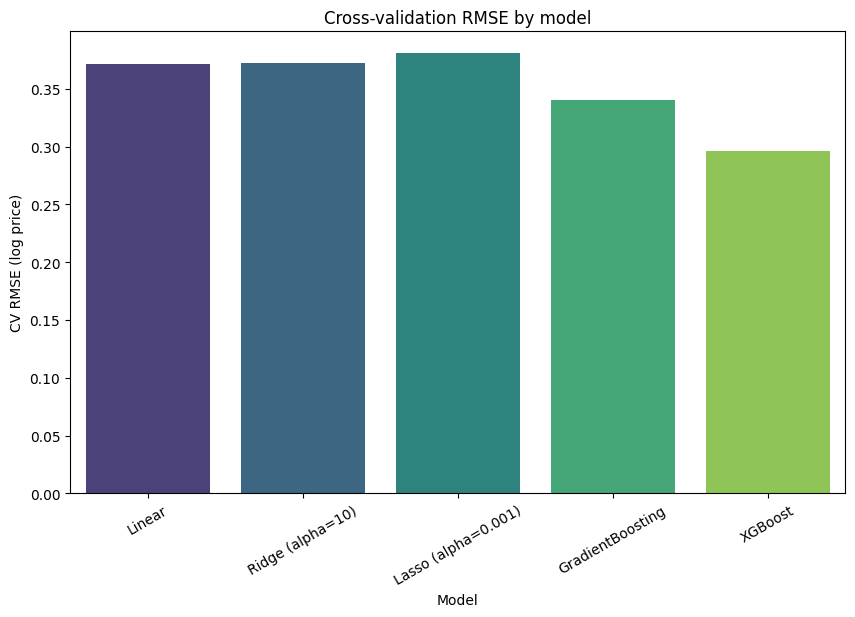

In [34]:
models = {
    "Linear": LinearRegression(),
    "Ridge (alpha=10)": Ridge(alpha=10),
    "Lasso (alpha=0.001)": Lasso(alpha=0.001, max_iter=5000),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=3, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6,
                            subsample=0.8, colsample_bytree=0.8, random_state=42)
}

cv_results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    display(f"{name} CV RMSE (log price): {-np.mean(scores):.4f}")
    cv_results[name] = -np.mean(scores)

# CV RMSE visualization
cv_df = pd.DataFrame({
    "Model": list(cv_results.keys()),
    "CV_RMSE_log": list(cv_results.values())
})
plt.figure(figsize=(10,6))
sns.barplot(data=cv_df, x="Model", y="CV_RMSE_log", palette="viridis")
plt.xticks(rotation=30)
plt.ylabel("CV RMSE (log price)")
plt.title("Cross-validation RMSE by model")
plt.show()


#### <span style="color: #ffa8B6;"> Test evaluation and predicted vs. actual visualization </span>
**Why:** Evaluate on held-out test set and visualize fit. Predicted vs. actual on price scale is more intuitive for dealers.

**Diagnostics:** Residual histogram helps identify bias or heteroskedasticity.

                 Model   RMSE_price    MAE_price
4              XGBoost  4746.604678  2828.194504
3     GradientBoosting  5809.493717  3550.298611
0               Linear  6348.667562  3982.925396
1     Ridge (alpha=10)  6370.655873  3986.018586
2  Lasso (alpha=0.001)  6461.846452  4071.033180


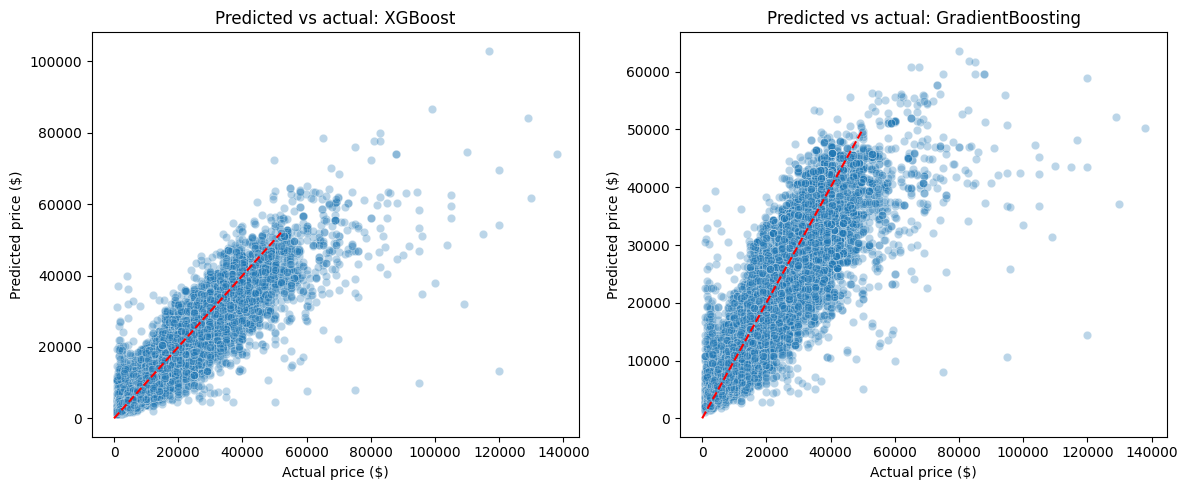

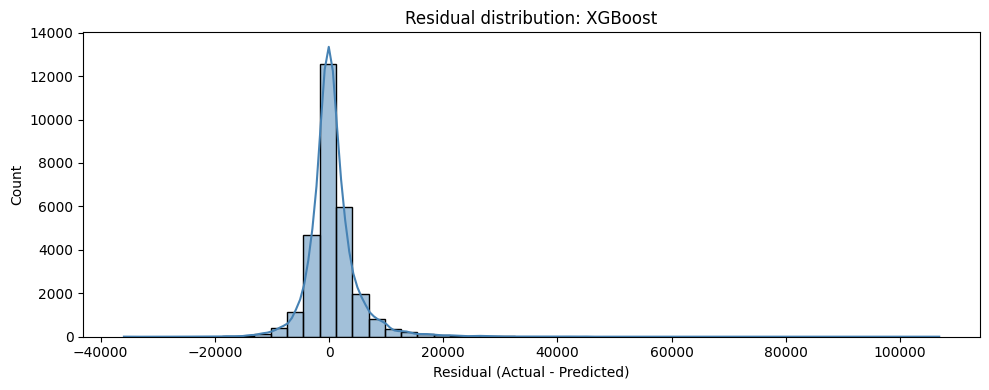

In [ ]:
# Fit all models
fitted = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    fitted[name] = model

def evaluate_on_test(model, name):
    y_pred_log = model.predict(X_test)
    y_pred = np.expm1(y_pred_log)
    y_true = np.expm1(y_test)
    
    # Compute RMSE manually for compatibility
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    mae = mean_absolute_error(y_true, y_pred)
    return {"Model": name, "RMSE_price": rmse, "MAE_price": mae}

results = [evaluate_on_test(m, n) for n, m in fitted.items()]
res_df = pd.DataFrame(results).sort_values("RMSE_price")
print(res_df)

# Predicted vs actual scatter for top 2 models
top2 = res_df['Model'].head(2).tolist()
plt.figure(figsize=(12,5))
for i, mdl_name in enumerate(top2, 1):
    mdl = fitted[mdl_name]
    y_pred_log = mdl.predict(X_test)
    y_pred = np.expm1(y_pred_log)
    y_true = np.expm1(y_test)
    plt.subplot(1,2,i)
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.3)
    maxp = np.percentile(np.concatenate([y_true, y_pred]), 99)
    plt.plot([0, maxp], [0, maxp], color='red', linestyle='--')
    plt.xlabel("Actual price ($)"); plt.ylabel("Predicted price ($)")
    plt.title(f"Predicted vs actual: {mdl_name}")
plt.tight_layout(); plt.show()

# Residual distribution for best model
best_model_name = res_df.iloc[0]['Model']
best_model = fitted[best_model_name]
y_pred_best = np.expm1(best_model.predict(X_test))
y_true = np.expm1(y_test)
residuals = y_true - y_pred_best

plt.figure(figsize=(10,4))
sns.histplot(residuals, bins=50, kde=True, color='steelblue')
plt.title(f"Residual distribution: {best_model_name}")
plt.xlabel("Residual (Actual - Predicted)"); 
plt.ylabel("Count")
plt.tight_layout(); 
plt.show()


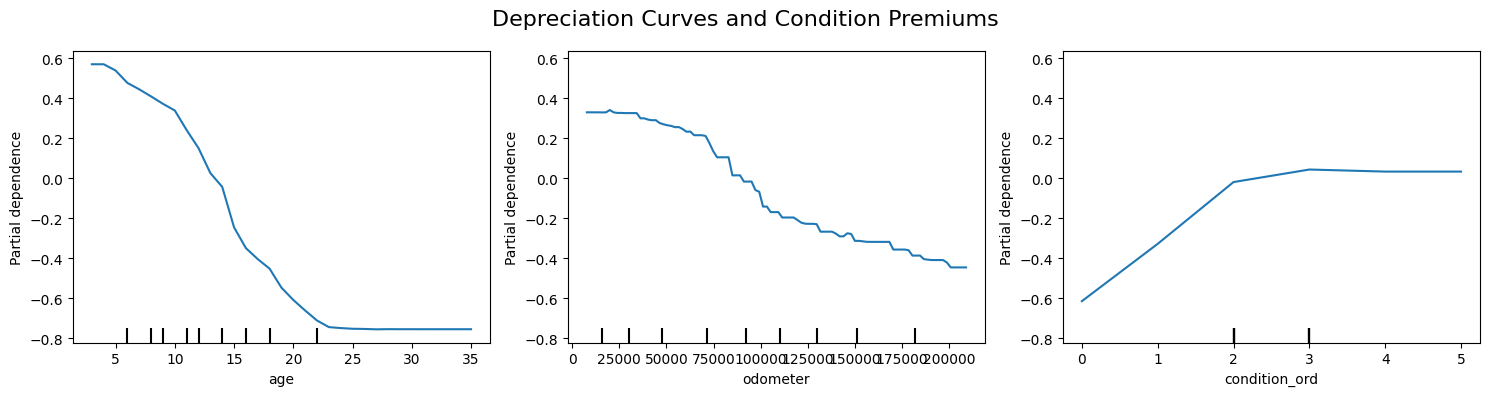

In [39]:

# Choose your best-performing tree-based model
best_model = fitted["GradientBoosting"]  # or fitted["XGBoost"]

# PDPs for age, mileage, condition
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
PartialDependenceDisplay.from_estimator(best_model, X_train, ['age','odometer','condition_ord'], ax=ax)
plt.suptitle("Depreciation Curves and Condition Premiums", fontsize=16)
plt.tight_layout()
plt.show()

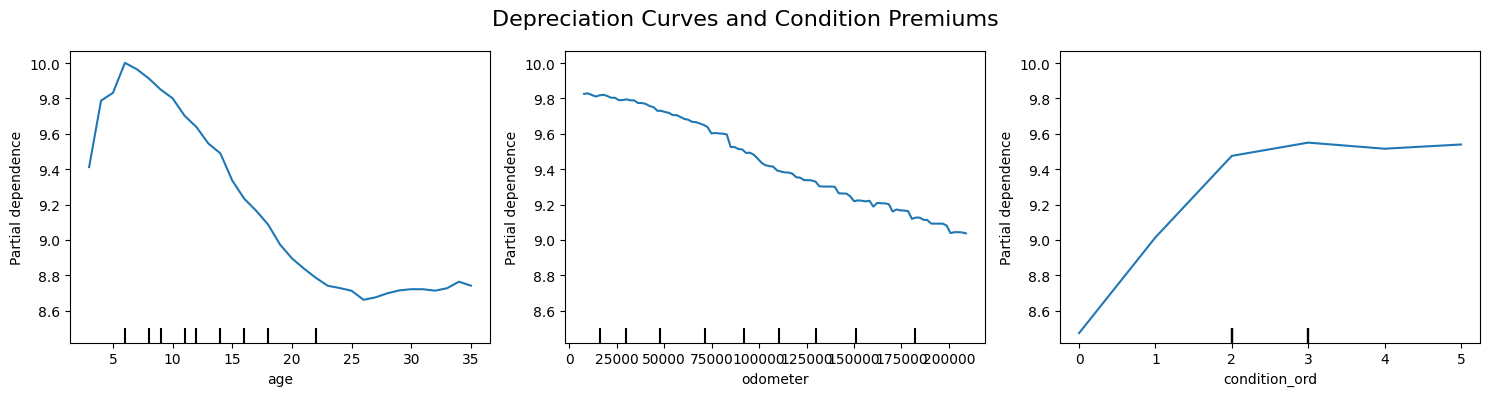

In [40]:
# Choose your best-performing tree-based model
best_model = fitted["XGBoost"]

# PDPs for age, mileage, condition
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
PartialDependenceDisplay.from_estimator(best_model, X_train, ['age','odometer','condition_ord'], ax=ax)
plt.suptitle("Depreciation Curves and Condition Premiums", fontsize=16)
plt.tight_layout()
plt.show()

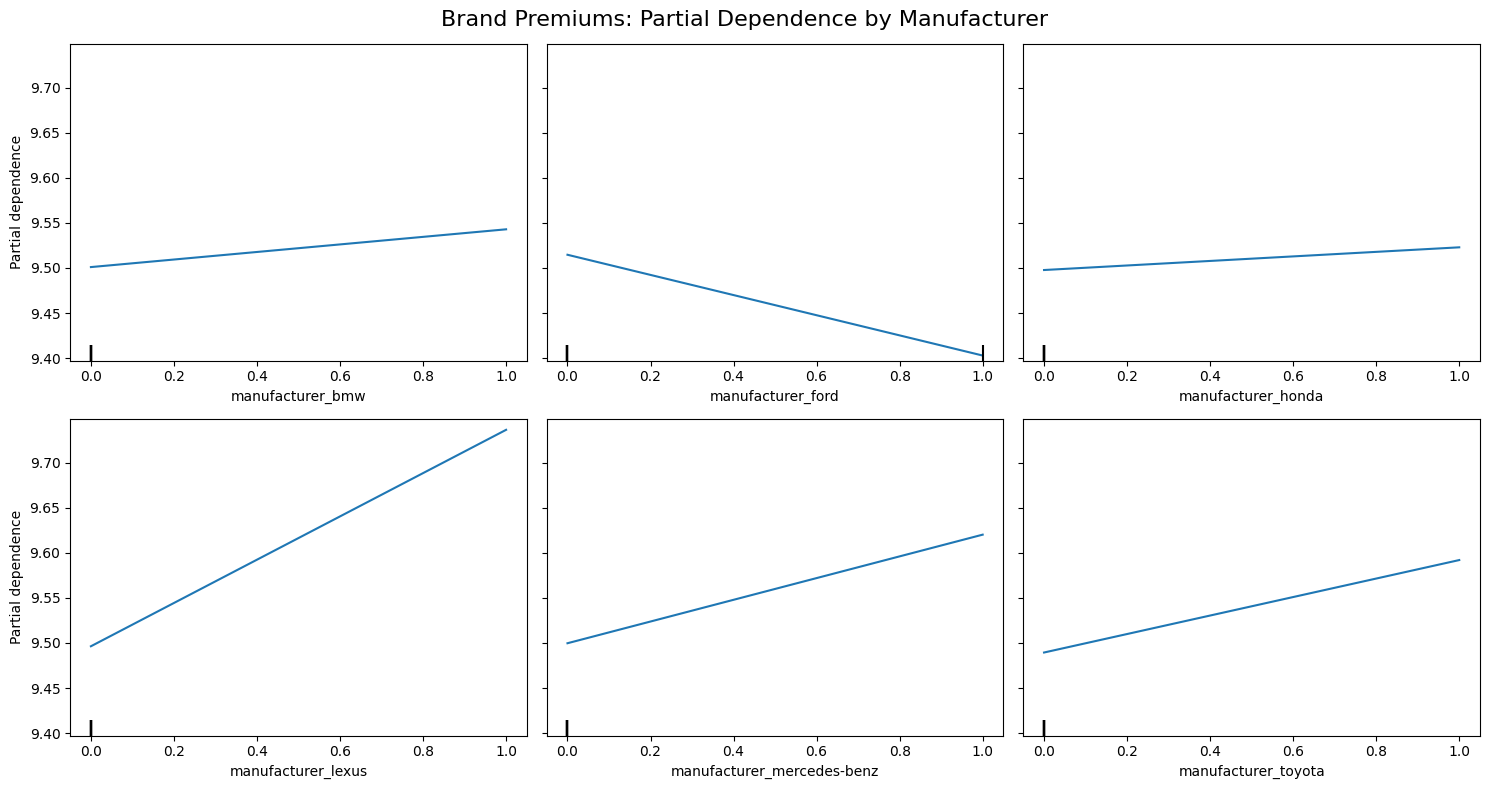

In [41]:
# Select a few major brands
brands_to_plot = [col for col in X_train.columns if col.startswith("manufacturer_")]
selected_brands = [b for b in brands_to_plot if any(x in b for x in ["toyota","ford","bmw","honda","mercedes","lexus"])]

fig, ax = plt.subplots(2, 3, figsize=(15, 8))
PartialDependenceDisplay.from_estimator(best_model, X_train, selected_brands, ax=ax)
plt.suptitle("Brand Premiums: Partial Dependence by Manufacturer", fontsize=16)
plt.tight_layout()
plt.show()

## <span style="color: #9df9ef;"> Deployment </span>

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

# 📊 Used Car Price Prediction Report
**Prepared for: Dealership**  
**Objective:** Fine-tune inventory strategy and pricing using data-driven insights.

---

## 1. Executive Summary
We analyzed a large dataset of used vehicles to identify the key drivers of resale price and built predictive models to quantify their impact.  

- **Best-performing model:** XGBoost, which captures non-linear depreciation and brand/condition effects.  
- **Key findings:** Age, mileage, and condition are the strongest predictors of price. Brand and vehicle type add measurable premiums.  
- **Business impact:** Dealers can optimize acquisition, reconditioning, and pricing strategies based on these insights.

---

## 2. Data Preparation
- **Cleaned variables:** Converted cylinders to numeric, mapped condition to ordinal scale, derived vehicle age.  
- **Target:** Log-transformed price for stability.  
- **Features used:** Age, mileage, cylinders, condition, fuel, transmission, drive, type, manufacturer, state.  
- **Encoding:** One-hot encoding for categorical variables (manufacturer, type, etc.).

---

## 3. Model Comparison

| Model              | RMSE (Price, $) | MAE (Price, $) |
|--------------------|-----------------|----------------|
| **XGBoost**        | **4,746.60**    | **2,828.19**   |
| GradientBoosting   | 5,809.49        | 3,550.30       |
| Linear Regression  | 6,348.67        | 3,982.93       |
| Ridge (alpha=10)   | 6,370.66        | 3,986.02       |
| Lasso (alpha=0.001)| 6,461.85        | 4,071.03       |

**Takeaway:**  
- XGBoost is the most accurate, reducing pricing error by ~$1,500 compared to linear models.  
- Gradient Boosting also performs well, but with higher error.  
- Linear, Ridge, and Lasso models are less suited for capturing complex depreciation and brand effects.

---

## 4. Key Insights from Visualizations

### Depreciation Curves
- **Age:** Steep price decline in first 5–7 years, then flattens.  
- **Mileage:** Strong negative effect, especially in first 50k miles.  

### Condition Premiums
- Step-wise uplift: “good” → “excellent” → “like new.”  
- Reconditioning investments are justified when uplift exceeds cost.  

### Brand Effects
- **Luxury brands (BMW, Mercedes, Lexus):** Higher baseline premiums.  
- **Mass-market (Toyota, Honda, Ford):** Mid-range values, strong resale reliability.  
- **Budget brands (Kia, Hyundai):** Lower resale values, require sharper discounting.

---

## 5. Dealer-Facing Recommendations
- **Acquisition Strategy:**  
  - Prioritize newer, low-mileage vehicles.  
  - Focus on brands with strong resale premiums.  

- **Pricing Strategy:**  
  - Use mileage and age tiers to set discounts.  
  - Apply condition premiums consistently to justify reconditioning costs.  

- **Inventory Mix:**  
  - Stock more SUVs and trucks (higher average resale).  
  - Adjust mix by region (e.g., trucks in Texas, hybrids in California).  

---

## 6. Next Steps
- Deploy XGBoost model as a **pricing engine**.  
- Integrate dashboards showing depreciation curves and brand premiums for ongoing decision support.  
- Periodically retrain models with fresh data to capture market shifts.  

---

✅ **Bottom Line for Dealers:**  
Data-driven pricing reduces error margins, maximizes resale value, and guides smarter inventory acquisition. Mileage, age, condition, and brand are the levers that matter most — and our models quantify their impact with precision.
